## Loading packages, settings and eval data

In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skm

from os import PathLike
from IPython.display import display
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy.stats import spearmanr
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from typing import cast, Tuple
from random import randint
from PIL import Image

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

set_custom_plot_style()
cm = 1 / 2.54

export = False

eval = MammaliaEval(
    path_config='../../data/path_config.yml',
    metrics=['balanced_accuracy_score'],
    force_metrics=False
    )

Loading pre-calculated metrics from file...


## Dataset analysis

In [ ]:
# Plot available Sequences per Label
########################################################################################################################
fig_name = "label2_session"
fig_size = (10*cm,10*cm)
########################################################################################################################

df = eval.raw_df.copy()

df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
    )

session_totals = counts_sorted.sum(axis=0)
new_labels = [f"{col} (n={session_totals[col]})" for col in counts_sorted.columns]
ax.legend(title='Session', labels=new_labels, loc='upper right')

ax.set_xlabel("Categories")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
# ax.legend(title="Session", loc='upper right')

plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)

plt.show()

In [ ]:
# Plot Histogram of Sequence Lengths
########################################################################################################################
fig_name = 'seq_len_histograms'
fig_size = (14*cm,7*cm)
########################################################################################################################

total_sequences = len(eval.raw_df.copy())

# Print percentage of sequences above each threshold
thresholds = [50, 100, 200, 500]
for t in thresholds:
    count = (df['n_files'] > t).sum()
    percent = count / total_sequences * 100
    print(f'Sequences with n_files > {t}: {count} ({percent:.2f}%)')

# Optionally, list the very largest sequence lengths
print('\nTop 10 sequence lengths:')
print(df['n_files'].nlargest(10).values)

plt.figure(figsize=fig_size)

ax1 = plt.subplot(1, 2, 1)
plt.hist(df['n_files'][df['n_files'] <= 50], bins=10, edgecolor='black')
plt.xlabel('Number of Files per Sequence (len ≤ 50)')
plt.ylabel('Count')
plt.title('Zoomed-in Histogram')
plt.xlim(0, 50)
ax1.set_xticks(np.arange(0, 51, 5))

# Right subplot: full range
ax2 = plt.subplot(1, 2, 2)
plt.hist(df['n_files'], bins=20, edgecolor='black')
plt.xlabel('Number of Files per Sequence')
plt.title('Full Range Histogram')
ax2.set_xticks(np.arange(0, 1000, 100))

plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)

plt.show()
    

In [ ]:
# Session info table
########################################################################################################################
table_name = 'session_info'
caption = r'Information about the origin of the different sessions in the dataset.'
########################################################################################################################

session_info = {
    1 : "Data from 'the wild', collected durch Wiesel&Co 2019",
    2 : "Data from 'the wild', collected during WILMA (SummerSchool) 2020",
    3 : "Data from 'the wild', collected by Vogelwarte 2020",
    4 : "Data from 'the wild', collected by WILMA (Bachelorthesis) 2020",
    5 : "Data from 'the wild', collected by WILMA (Roland) 2020 (Contains images and videos of stoats (Mustela erminea))",
    6 : "Data from an enclosure, collected by Nils (Contains only images of stoats (Mustela erminea))",
    7 : "Data gathered from Nathalie Straub in her Bachelor Thesis"
    }

session_desc = pd.DataFrame.from_dict(
    session_info, 
    orient='index', 
    columns=['description']
    ).reset_index().rename(columns={'index': 'session'})

latex_str = session_desc.to_latex(
    index=False,
    column_format='c p{12cm}',
    escape=True,
    header=['Session', 'Description'],
    caption=caption,
    label=f'tab:{table_name}'
    )

latex_str = place_table(latex_str, center=True, placement='H')

print(latex_str)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex_str)


In [ ]:
# Plot Fraction of Discarded Images by Applied Confidence
########################################################################################################################
fig_name = 'discarded_img_by_conf'
fig_size = (12*cm,7*cm)
conf_threshold = 0.5
########################################################################################################################

df = eval.image_df.copy()

cdf_data = (
    df.sort_values(by='conf')
      .groupby('class_label', group_keys=False)
      .apply(lambda g: pd.DataFrame({
          'conf': np.sort(g['conf'].to_numpy()),
          'cum_density': np.linspace(0, 1, len(g)),
          'class_label': g.name  # this is the current group label
      }), include_groups=False)
      .reset_index(drop=True)
)

# Plotting
class_counts = df['class_label'].value_counts().to_dict()

plt.figure(figsize=fig_size)
for class_label, group in cdf_data.groupby('class_label'):
    count = class_counts.get(class_label, 0)
    label = f'{class_label} (n={count/1000:.1f}K)'
    
    line, = plt.plot(group['conf'], group['cum_density'], label=label)

    above_thresh = group[group['conf'] >= conf_threshold]
    if not above_thresh.empty:
        y_at_thresh = above_thresh['cum_density'].iloc[0]
        plt.hlines(y=y_at_thresh, xmin=0.24, xmax=conf_threshold, linestyle='--', alpha=0.5, color=line.get_color())

plt.axvline(x=conf_threshold, linestyle='--', color='gray', alpha=0.5)
plt.text(
    x=conf_threshold, y=1.08,
    s=f'Confidence Threshold = {conf_threshold}',
    horizontalalignment='center',
    fontsize=8,
    color='gray'
)

plt.xlabel('Applied Confidence')
plt.ylabel('Fraction of Images Discarded (log scale)')
plt.yscale('log')
plt.yticks(
    [0.05, 0.07, 0.1, 0.2, 0.5, 1], 
    labels=['5%', '7%', '10%', '20%', '50%', '100%']
    )
plt.xticks(
    np.arange(0.25, 1, 0.1),
    labels=[f'{x:.2f}' for x in np.arange(0.25, 1, 0.1)]
)
plt.legend(
    loc='lower right',
    bbox_to_anchor=(1, -0.03),
    frameon=False
)
plt.xlim(left=0.25, right=1)
plt.ylim(bottom=0.04, top=1)
plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
plt.show()

In [ ]:
# MD output - data available
########################################################################################################################
table_name = 'data_availability_after_md'
caption = r'Data loss dew to \acs{MD} output for confidence thresholds of 0.25 and 0.5 by category for the image and the sequence level.'
########################################################################################################################

df_seq = count_vs_threshold(eval.sequence_df.copy(), thresholds=[0.25, 0.5], base_name="seq")
df_img = count_vs_threshold(eval.image_df.copy(), thresholds=[0.25, 0.5], base_name="img")
joined_df = df_img.merge(df_seq, on='class_label')

keys = joined_df.keys()

lines = [
        '\\begin{table}',
        f'\\caption{{{caption}}}',
        f'\\label{{tab:{table_name}}}',
        '\\begin{tabular}{l r r r r}',
        '\\toprule'
        ]

last = 'first'
key_l = ''
treshold = '0'

for key in keys:

    info = key.split('_')

    if info[0] != last:
        
        if info[0] == 'seq':
            lines.append('\midrule')
            lines.append('\\textbf{Sequence Level} & & & & \\\\')
        elif info[0] == 'img':
            lines.append('\midrule')
            lines.append('\midrule')
            lines.append('\\textbf{Image Level} & & & & \\\\')
        
    last = info[0]
    
    if len(info) == 2:
        key_l = 'Total available'
    elif len(info) == 3:
        if info[2] != treshold:
            lines.append('\midrule')
            lines.append(f'Threshold of {info[2]}: & & & & \\\\')
            treshold = info[2]

        if info[1] == 'lost':
            key_l = 'Lost'
        elif info[1] == 'frac':
            key_l = 'Percentage lost'
        elif info[1] == 'avail':
            key_l = 'Available'


    data = joined_df[key].values

    data_str = ''

    for value in data:
        if isinstance(value, str):
            value = value.replace('_', '\_')
            key_l = ''
        elif key_l == 'Percentage lost':
            value = f'{value:.0%}'.replace('%', '\\%')
        else:
            value = str(value)
        
        data_str += ' & ' + value

    new_line = key_l + data_str + ' \\\\'
    lines.append(new_line)

lines.extend([
    '\\bottomrule',
    '\\end{tabular}',
    '\\end{table}'
    ])

latex = "\n".join(lines)
latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)
        

In [ ]:
# Detections of a Sequence
########################################################################################################################
fig_name = 'detections_on_a_sequence'
fig_width = 14*cm
seq_id = 1001824
scaling_factor = 0.5
########################################################################################################################


dataset_seq = MammaliaDataSequence(
    path_labelfiles=eval.paths['labels'],
    path_to_dataset=eval.paths['dataset'],
    path_to_detector_output=eval.paths['md_output'],
    detector_model=None,
    mode='eval'
    )

i = dataset_seq.get_index_by_seq_id(seq_id)
sequence = dataset_seq[i]

length = len(sequence['sample'])

if length >= 6:
    nrows = 3
    ncols = 2
else:
    raise ValueError("The sequence is too short to be displayed in a 3x2 grid.")

fig = plt.figure(figsize=(fig_width, fig_width * nrows / ncols * 3/4))
gs = GridSpec(
    nrows=nrows, ncols=ncols,
    figure=fig,
    )

for col in range(ncols):
    for row in range(nrows):
        ax = fig.add_subplot(gs[row, col])

        if col == 0:
            idx = row
        else:
            idx = -(nrows - row)

        sample = {
            'img': sequence['sample'][idx],
            'bbox': sequence['bbox'][idx],
            'conf': sequence['conf'][idx]
            }

        draw_bbox_on_ax(ax, sample)

fig.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
plt.show()

## Model analysis

### Balanced Accuracy of all Models

In [ ]:
# Balanced accuracy Table for all models
########################################################################################################################
table_name = 'bal_acc_by_model'
caption = r'\acs{BA} of all models --- mean ± standard deviation; best values highlighted.'
########################################################################################################################

summary_bal_acc = (
    eval.metrics_df.copy()
    .loc[eval.metrics_df['metric'] == 'balanced_accuracy_score']
    .groupby(['model_name', 'pretrained'])
    .agg(
        trainable_params=('trainable_params', 'first'),
        img_score_mean=('img_score', 'mean'),
        img_score_std =('img_score', 'std'),
        seq_score_mean=('seq_score', 'mean'),
        seq_score_std =('seq_score', 'std'),
    )
    .reset_index()
    .sort_values(
        by=['pretrained', 'trainable_params'],
        ascending=[False, True]
    )
    )

summary_bal_acc['model_name'] = summary_bal_acc['model_name'].str.replace('_', r'\_')

for scope in ['img', 'seq']:
    best_idx = summary_bal_acc[f'{scope}_score_mean'].idxmax()

    for idx in summary_bal_acc.index:
        mean = summary_bal_acc.at[idx, f'{scope}_score_mean']
        std = summary_bal_acc.at[idx, f'{scope}_score_std']
        if idx == best_idx:
            box_color = 'gray!20'
        else:
            box_color = 'white'
        summary_bal_acc.at[idx, f'bal_acc_{scope}'] = (
            rf'\colorbox{{{box_color}}}{{{mean:.4f}}} ± {std:.3f}'
        )


table = (
        summary_bal_acc[
            ['model_name', 'pretrained', 'trainable_params', 'bal_acc_img', 'bal_acc_seq']
        ]
        .rename(columns={
            'model_name': 'Model',
            'pretrained': 'Pretrained',
            'trainable_params': 'Params (M)',
            'bal_acc_img': r'Image \acs{BA}',
            'bal_acc_seq': r'Sequence \acs{BA}'
        }))

table['Params (M)'] = (table['Params (M)'] / 1_000_000).astype(int)
table['Pretrained'] = table['Pretrained'].map({True: 'Yes', False: 'No'})

latex = table.to_latex(
    index=False,
    column_format='l c r c c',
    escape=False,
    caption=caption,
    label=f'tab:{table_name}',
    )

lines = latex.splitlines()

for i, line in enumerate(lines):
    if '& No &' in line:
        split_index = i
        break

new_lines = lines[:split_index] + ['\midrule'] + lines[split_index:]

latex = "\n".join(new_lines)

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)



In [ ]:
# Box Plot for Balanced Accuracy by Model and Pretrained Status
########################################################################################################################
fig_name = 'bal_acc_img'
fig_size = (12*cm,7*cm)
########################################################################################################################

bal_acc = (
    eval.metrics_df.copy()
    .loc[eval.metrics_df['metric'] == 'balanced_accuracy_score']
    )

models = ['efficientnet_b0', 'densenet169','resnet50', 'vit_b_16']
n = len(models)
x = range(n)
width = 0.35

data_pre = [
    bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score'] 
    for m in models
    ]
data_no = [
    bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score'] 
    for m in models
    ]

cmap = plt.get_cmap('Pastel1')
color_pre = cmap(2)
color_no  = cmap(3)
red = cmap(0)

plt.figure(figsize=fig_size)

medianprops = dict(linewidth=1, color=red)

meanprops = dict(
                marker='D',
                markeredgecolor=red,
                markerfacecolor=red,
                markersize=6
                )

flierprops = dict(marker='', linestyle='none')

bp_pre = plt.boxplot(
    data_pre,
    positions=[i - width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
    )
bp_no = plt.boxplot(
    data_no,
    positions=[i + width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops,
    flierprops=flierprops
    )

for box in bp_pre['boxes']:
    box.set_facecolor(color_pre)
    box.set_edgecolor('gray')
for box in bp_no['boxes']:
    box.set_facecolor(color_no)
    box.set_edgecolor('gray')

plt.xticks(x, models, ha='center')
plt.xlabel('Model')
plt.ylabel('BalAcc (Image)')

legend_handles = [
    Patch(facecolor=color_pre, edgecolor='gray', label='Pretrained'),
    Patch(facecolor=color_no,  edgecolor='gray', label='Not Pretrained')
    ]
plt.legend(handles=legend_handles, frameon=False, loc='lower left')

for i, m in enumerate(models):
    y_pre = bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score']
    x_pre = np.random.normal(i - width/2, width*0.05, size=len(y_pre))
    plt.scatter(x_pre, y_pre, color=color_pre, edgecolor='gray', zorder=2)

    y_no  = bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score']
    x_no  = np.random.normal(i + width/2, width*0.05, size=len(y_no))
    plt.scatter(x_no, y_no, color=color_no,  edgecolor='gray', zorder=2)


plt.tight_layout()

if export:
    plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

### Performance of Best Model

In [ ]:
# Training metrics for best model
########################################################################################################################
fig_name = 'training_metrics_best_model'
fig_size = (12*cm, 14*cm)
########################################################################################################################

def process_metrics(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .loc[:, ['epoch'] + [col for col in df.columns if col.startswith('val_')]]
        .pipe(lambda d: d.dropna(subset=[col for col in d.columns if col != 'epoch'], how='all'))
        .assign(epoch=lambda d: d['epoch'].astype(int) + 1)
        )

train_metrics = eval.best_model.get_training_metrics(process=process_metrics).copy()

fig, axes = plt.subplots(2, 1, figsize=fig_size, sharex=True)

# Titles and y-axis labels for both plots
metrics = ['val_loss','val_acc']
ylabels = ['Validation Loss', 'Validation Accuracy']

all_epochs = sorted(set().union(*[df['epoch'] for df in train_metrics]))

for i, metric in enumerate(metrics):
    ax = axes[i]
    for fold_idx, df in enumerate(train_metrics):
        # Plot the line and capture the Line2D object to get the color
        line, = ax.plot(df['epoch'], df[metric], label=f'Fold {fold_idx}')
        color = line.get_color()

        # Find best point: min for loss, max for balanced accuracy
        if metric == 'val_loss':
            idx = df[metric].idxmin()
        else:  # 'val_bal_acc'
            idx = df[metric].idxmax()

        best_epoch = df.loc[idx, 'epoch']
        best_value = df.loc[idx, metric]

        # Highlight point using same color
        ax.plot(best_epoch, best_value, 'o', color=color)

    ax.set_ylabel(ylabels[i])
    ax.set_xticks(all_epochs)

    if i == 1:
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')

plt.tight_layout()
if export:
        plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

In [ ]:
# Confusion Matrix for the best model
########################################################################################################################
fig_name = 'conf_matrix_best'
fig_size = (12*cm,12*cm)
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

y_true = df['class_id'].to_list()
y_pred = df['pred_id'].to_list()

labels = list(eval.best_model.decoder.values())

confusion_matrix = skm.confusion_matrix(
    y_true,
    y_pred,
    labels=list(eval.best_model.decoder.keys()),
    normalize='true'
    )

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=labels)
fig, ax = plt.subplots(figsize=fig_size)
disp.plot(
    ax=ax,
    cmap='Blues',
    colorbar=False,
    values_format='.4f'
    )

n = len(labels)
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=90, va='center')

plt.tight_layout()
if export:
        plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

In [ ]:
# Precision, Recall and F1-Score for the best model
########################################################################################################################
table_name = 'precision_recall_fscore_support'
caption = r'Class-wise precision, recall, F1-score, and support for the best-performing model.'
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

y_true = df['class_id'].to_list()
y_pred = df['pred_id'].to_list()

labels_ids = [k for k in eval.best_model.decoder]

result  = skm.precision_recall_fscore_support(
    y_true,
    y_pred,
    labels=list(eval.best_model.decoder.keys()),
    zero_division=0
    )

precision, recall, f1_score, support = cast(
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray],
    result
    )

data = []
for i, label in enumerate(list(eval.best_model.decoder.values())):
    data.append({
        'Class'    : label,
        'Precision': precision[i],
        'Recall'   : recall[i],
        'F1-Score' : f1_score[i],
        'Support'  : int(support[i]),
    })

df = pd.DataFrame(data)

latex = df.to_latex(
    index=False,
    column_format='l r r r r',
    escape=True,
    float_format="%.3f",
    caption=caption,
    label=f'tab:{table_name}',
    )

latex = place_table(latex, center=True, placement='H')

print(latex)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex)


In [ ]:
# Searman Correlation between Detection Confidence and Class Confidence
########################################################################################################################
table_name = 'spearman_corr_det_class_conf'
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

rows = []

for correct in [True, False]:
    subset = df[df['correct'] == correct]
    det_conf = subset['conf']
    class_conf = subset['probs_max']
    valid = det_conf.notna() & class_conf.notna()

    rho, p_value = spearmanr(det_conf[valid], class_conf[valid])

    label = "For correctly classified samples:" if correct else "For misclassified samples:"

    # Format rho
    rho_str = rf"$\rho = {rho:.3f}$"

    rows.append(f"{label} & {rho_str} \\\\")

# Join everything into a LaTeX tabular block
latex_output = r"""\begin{tabular}{l l}
""" + "\n".join(rows) + "\n\\end{tabular}"

print(latex_output)

if export:
    with open(eval.paths['table'] / f'{table_name}.tex', 'w') as f:
        f.write(latex_output)

In [ ]:
# Prediction and Detection Confidence Hexbin Plot of Correct and Incorrect Predictions
########################################################################################################################
fig_name = 'pred_conf_hexbin'
fig_size = (14*cm, 7*cm)
########################################################################################################################

df = eval.best_model.full_predicted_set.copy()

df_correct = df[df['correct'] == True]
df_incorrect = df[df['correct'] == False]

gridsize = 80
linewidths = 0.01
mincnt = 0 

fig, axes = plt.subplots(1, 2, figsize=fig_size, sharex=True, sharey=True)

hb1 = axes[0].hexbin(
    df_correct['conf'], df_correct['probs_max'],
    gridsize=gridsize, mincnt=mincnt, cmap='Greens', bins='log', linewidths=linewidths
)
axes[0].set_title('Correct Classifications')
axes[0].set_xlabel('Detection Confidence')
axes[0].set_ylabel('Classifier Confidence')

hb2 = axes[1].hexbin(
    df_incorrect['conf'], df_incorrect['probs_max'],
    gridsize=gridsize, mincnt=mincnt, cmap='Oranges', bins='log', linewidths=linewidths
)
axes[1].set_title('Incorrect Classifications')
axes[1].set_xlabel('Detection Confidence')
axes[1].tick_params(axis='y', left=False, labelleft=False)

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.2)
    ax.set_xlim(0.5, 1)
    ax.set_ylim(0.5, 1.005)
    ax.set_aspect('equal', adjustable='box')

fig.colorbar(hb1, ax=axes[0], orientation='vertical', label='log10(N)', fraction=0.046, pad=0.04)
fig.colorbar(hb2, ax=axes[1], orientation='vertical', label='log10(N)', fraction=0.046, pad=0.04)

plt.tight_layout()
if export:
        plt.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
plt.show()

## Visual inspection of Detection

In [ ]:
# Visual of Mustela erminea with no detections
########################################################################################################################
fig_name = 'mustela_special_nodetect'
########################################################################################################################
df=eval.image_df.copy()

mustela_erminea_nodetect = [22374, 35835, 33248, 421320, 421394, 421465, 421507, 421590, 421664, 421712, 421959, 423864]
order = [0, 1, 2, 5, 6, 10, 11, 3, 4, 7, 8, 9]
mustela_erminea_nodetect = [mustela_erminea_nodetect[i] for i in order]

df_selected = df.loc[mustela_erminea_nodetect]

fig = plot_series_of_images(
    df=df_selected, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

In [ ]:
# Visual of Mustela erminea best detections
########################################################################################################################
fig_name = 'mustela_best'
start_id = 0
end_id = 12
########################################################################################################################
df = eval.image_df.copy()

filter = (df["conf"] >= 0.5) & (df["class_label"] == "mustela_erminea")
df_filtered = df.where(filter).dropna().sort_values(by='conf', ascending=False)
df_selected = df_filtered.iloc[start_id:end_id]

fig = plot_series_of_images(
    df=df_selected, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

In [ ]:
# Visual of Mustela erminea detection confidence just above 0.25 ---- not used
########################################################################################################################
fig_name = 'mustela_just_above25'
start_id = 0
end_id = 12
########################################################################################################################
df = eval.image_df.copy()

filter = (df["conf"] >= 0.25) & (df["class_label"] == "mustela_erminea")
df_filtered = df.where(filter).dropna().sort_values(by='conf', ascending=True)
df_selected = df_filtered.iloc[start_id:end_id]

fig = plot_series_of_images(
    df=df_selected, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

# if export:
#     fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

In [ ]:
# Visual of Mustela erminea detection confidence just above 0.5   ---- not used
########################################################################################################################
fig_name = 'mustela_just_above5'
start_id = 0
end_id = 12
########################################################################################################################
df = eval.image_df.copy()

filter = (df["conf"] >= 0.5) & (df["class_label"] == "mustela_erminea")
df_filtered = df.where(filter).dropna().sort_values(by='conf', ascending=True)
df_selected = df_filtered.iloc[start_id:end_id]

fig = plot_series_of_images(
    df=df_selected, 
    dataset_path=eval.paths['dataset'], 
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

# if export:
#     fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

In [ ]:
# Hand picked examples for false positive detections.
########################################################################################################################
fig_name = 'false_positive_dt'
########################################################################################################################
df=eval.best_model.full_predicted_set.copy()

ordered_selection = [65422, 71324, 61904, 89298, 141627, 29904, 144673, 381794, 47543]
df_filtered = df[df['idx'].isin(ordered_selection )]
df_filtered = df_filtered.set_index('idx').loc[ordered_selection ].reset_index()

fig = plot_series_of_images(
    df=df_filtered, 
    dataset_path=eval.paths['dataset'],
    annotation_type='both',
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=900
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

In [ ]:
# Snail Problem - Hand picked examples for false positive classifications containing snails
########################################################################################################################
fig_name = 'false_class_snails'
########################################################################################################################
df=eval.best_model.full_predicted_set.copy()

ordered_selection = [119992, 117471, 209198, 227109, 205344, 205345, 372009, 390188, 386088, 272377, 340151, 350399]
df_filtered = df[df['idx'].isin(ordered_selection )]
df_filtered = df_filtered.set_index('idx').loc[ordered_selection ].reset_index()

fig = plot_series_of_images(
    df=df_filtered, 
    dataset_path=eval.paths['dataset'],
    annotation_type='both',
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800
    )

if export:
    fig.savefig(eval.paths['figures'] / f'{fig_name}.pdf', dpi=300)
    
display(fig)

## Visual inspection of Detection

## Brows trough ds

In [ ]:
df = eval.best_model.full_predicted_set.copy()

df_filtered = (
    df
    .query('correct == False')
    .sort_values('probs_max', ascending=False)
    )

chunker = DFChunker(df_filtered, chunk_size=12)

In [ ]:
chunk = chunker.get_current_and_advance()
print(f"Showing chunk {chunker.current} of {len(chunker)} chunks")

plot_series_of_images(
    df=chunk, 
    dataset_path=eval.paths['dataset'],
    annotation_type='both',
    ncols=3, 
    fig_width_cm=24,
    offset_margin_conf_annotation=800,
    print_idx=True
    )

## Preparing Images for flow diagram

### selecting sequence

In [97]:
# defining specialized functions

pipeline = ImagePipeline(
    path_to_dataset=eval.paths['dataset'],
    pre_ops=[
        ('to_rgb', {}),
        ('crop_by_bb', {'crop_shape': 1.0})
        ],
    transform=None
    )

def process_image_series(
        chunk: pd.DataFrame,
        pipeline: ImagePipeline,
        font_size: int | None = None,
        line_width: int = 10
        ) -> list[dict[str, Image.Image]]:


    images = []
    for n, row in enumerate(chunk.itertuples()):
        image_path = eval.paths['dataset'] / str(row.file_path)
        img = Image.open(image_path)
        bbox = row.bbox
        conf = row.conf

        if conf > 0:
            img_cropped = pipeline(image_path, bbox).resize((1000, 1000))
        else:
            img_cropped = Image.new("RGB", (1000, 1000), color="white")

        img_bbox = draw_bbox_on_image(
            image=img.copy(),
            bbox=bbox,
            conf=conf,
            font_size=font_size,
            line_width=line_width,
            )
        
        row_dict = row._asdict()

        image_entry = {
            'img': img,
            'img_bbox': img_bbox,
            'img_cropped': img_cropped,
            }
        
        image_entry.update(row_dict)

        images.append(image_entry)
    
    return images


def plot_for_seq_id(
        seq_id: int,
        fig_size: tuple[float, float] = (10, 15),
        silent: bool = False
        ) -> Figure | None:

    df = eval.image_df.copy()

    chunk = df[df["seq_id"] == seq_id]

    if len(chunk) != 6:
        if not silent:
            print(f"Sequence {seq_id} does not have exactly 6 images, skipping.")
        return

    if not silent:
        print(f"Plotting sequence {seq_id}")

    pipeline = ImagePipeline(
        path_to_dataset=eval.paths['dataset'],
        pre_ops=[
            ('to_rgb', {}),
            ('crop_by_bb', {'crop_shape': 1.0})
            ],
        transform=None
        )

    images = []
    for n, row in enumerate(chunk.itertuples()):
        image_path = eval.paths['dataset'] / str(row.file_path)
        img = Image.open(image_path)
        bbox = row.bbox
        conf = row.conf

        if conf > 0:
            img_cropped = pipeline(image_path, bbox).resize((1000, 1000))
        else:
            img_cropped = Image.new("RGB", (1000, 1000), color="white")

        img_bbox = draw_bbox_on_image(
            image=img.copy(),
            bbox=bbox,
            conf=conf,
            font_size=74,
            line_width=10,
            )

        images.append({
            'img': img,
            'img_bbox': img_bbox,
            'img_cropped': img_cropped
            })

    fig = plt.figure(figsize=fig_size)
    gs = GridSpec(
        nrows=6,
        ncols=3,
        figure=fig,
        )

In [ ]:
# filtering the dataframe

# df = eval.image_df.copy()

# agg_df = df.groupby("seq_id").agg(
#     items=("seq_id", "count"),
#     conf_zero=("conf", lambda x: (x == 0).sum()),
#     conf_mid=("conf", lambda x: ((x > 0) & (x < 0.5)).sum())
# ).reset_index()

# # Filter sequences with 6 items and exactly 2 images with confidence 0
# mask = agg_df[
#     (agg_df["items"] == 6) &
#     (agg_df["conf_zero"] == 1) &
#     (agg_df["conf_mid"] == 1)
# ]

# df_filtered = df[df["seq_id"].isin(mask["seq_id"])]

# seq_id_list = df_filtered["seq_id"].unique().tolist()

# out_path = eval.paths['output'] / 'image_series'


In [ ]:
# Save plots for each sequence in current filtered list

# for current_seq_id in seq_id_list:

#     fig = plot_for_seq_id(
#         current_seq_id,
#         fig_size=(24*cm, 24*cm),
#         silent=True
#         )

#     if fig:
#         fig.savefig(out_path / f'seq_{current_seq_id}.pdf', dpi=300)


In [100]:
# Extracting all needed for the flow chart
########################################################################################################################
selected_seq_id = 4002072

########################################################################################################################

output_path = eval.paths['output'] / f'edited_seq_{selected_seq_id}_2'
output_path.mkdir(parents=True, exist_ok=False)

df_pred = eval.best_model.full_predicted_set.copy()
df_pred = df_pred[df_pred['seq_id'] == selected_seq_id]

df_det = eval.image_df.copy()
df_det = df_det[df_det['seq_id'] == selected_seq_id]

common_cols = set(df_det.columns).intersection(df_pred.columns) - {'file_path'}
df_pred = df_pred.drop(columns=common_cols)

df_joined = df_det.merge(
    df_pred,
    on='file_path',
    suffixes=('_det', '_pred'),
    how='outer'
    )

pipeline = ImagePipeline(
    path_to_dataset=eval.paths['dataset'],
    pre_ops=[
        ('to_rgb', {}),
        ('crop_by_bb', {'crop_shape': 1.0})
        ],
    transform=None
    )

images = process_image_series(
        df_joined,
        pipeline,
        font_size=120,
        line_width=10
        )

info = {}
img_keys = ['img', 'img_bbox', 'img_cropped']

for n, image in enumerate(images):
    

    for key in img_keys:
        object = image[key]

        object.save(output_path / f'{n}_{key}.jpg', quality=95)

    info[n] = {k: v for k, v in image.items() if k not in img_keys}
    
with open(output_path / 'info.json', 'w') as f:
    json.dump(info, f, indent=2)


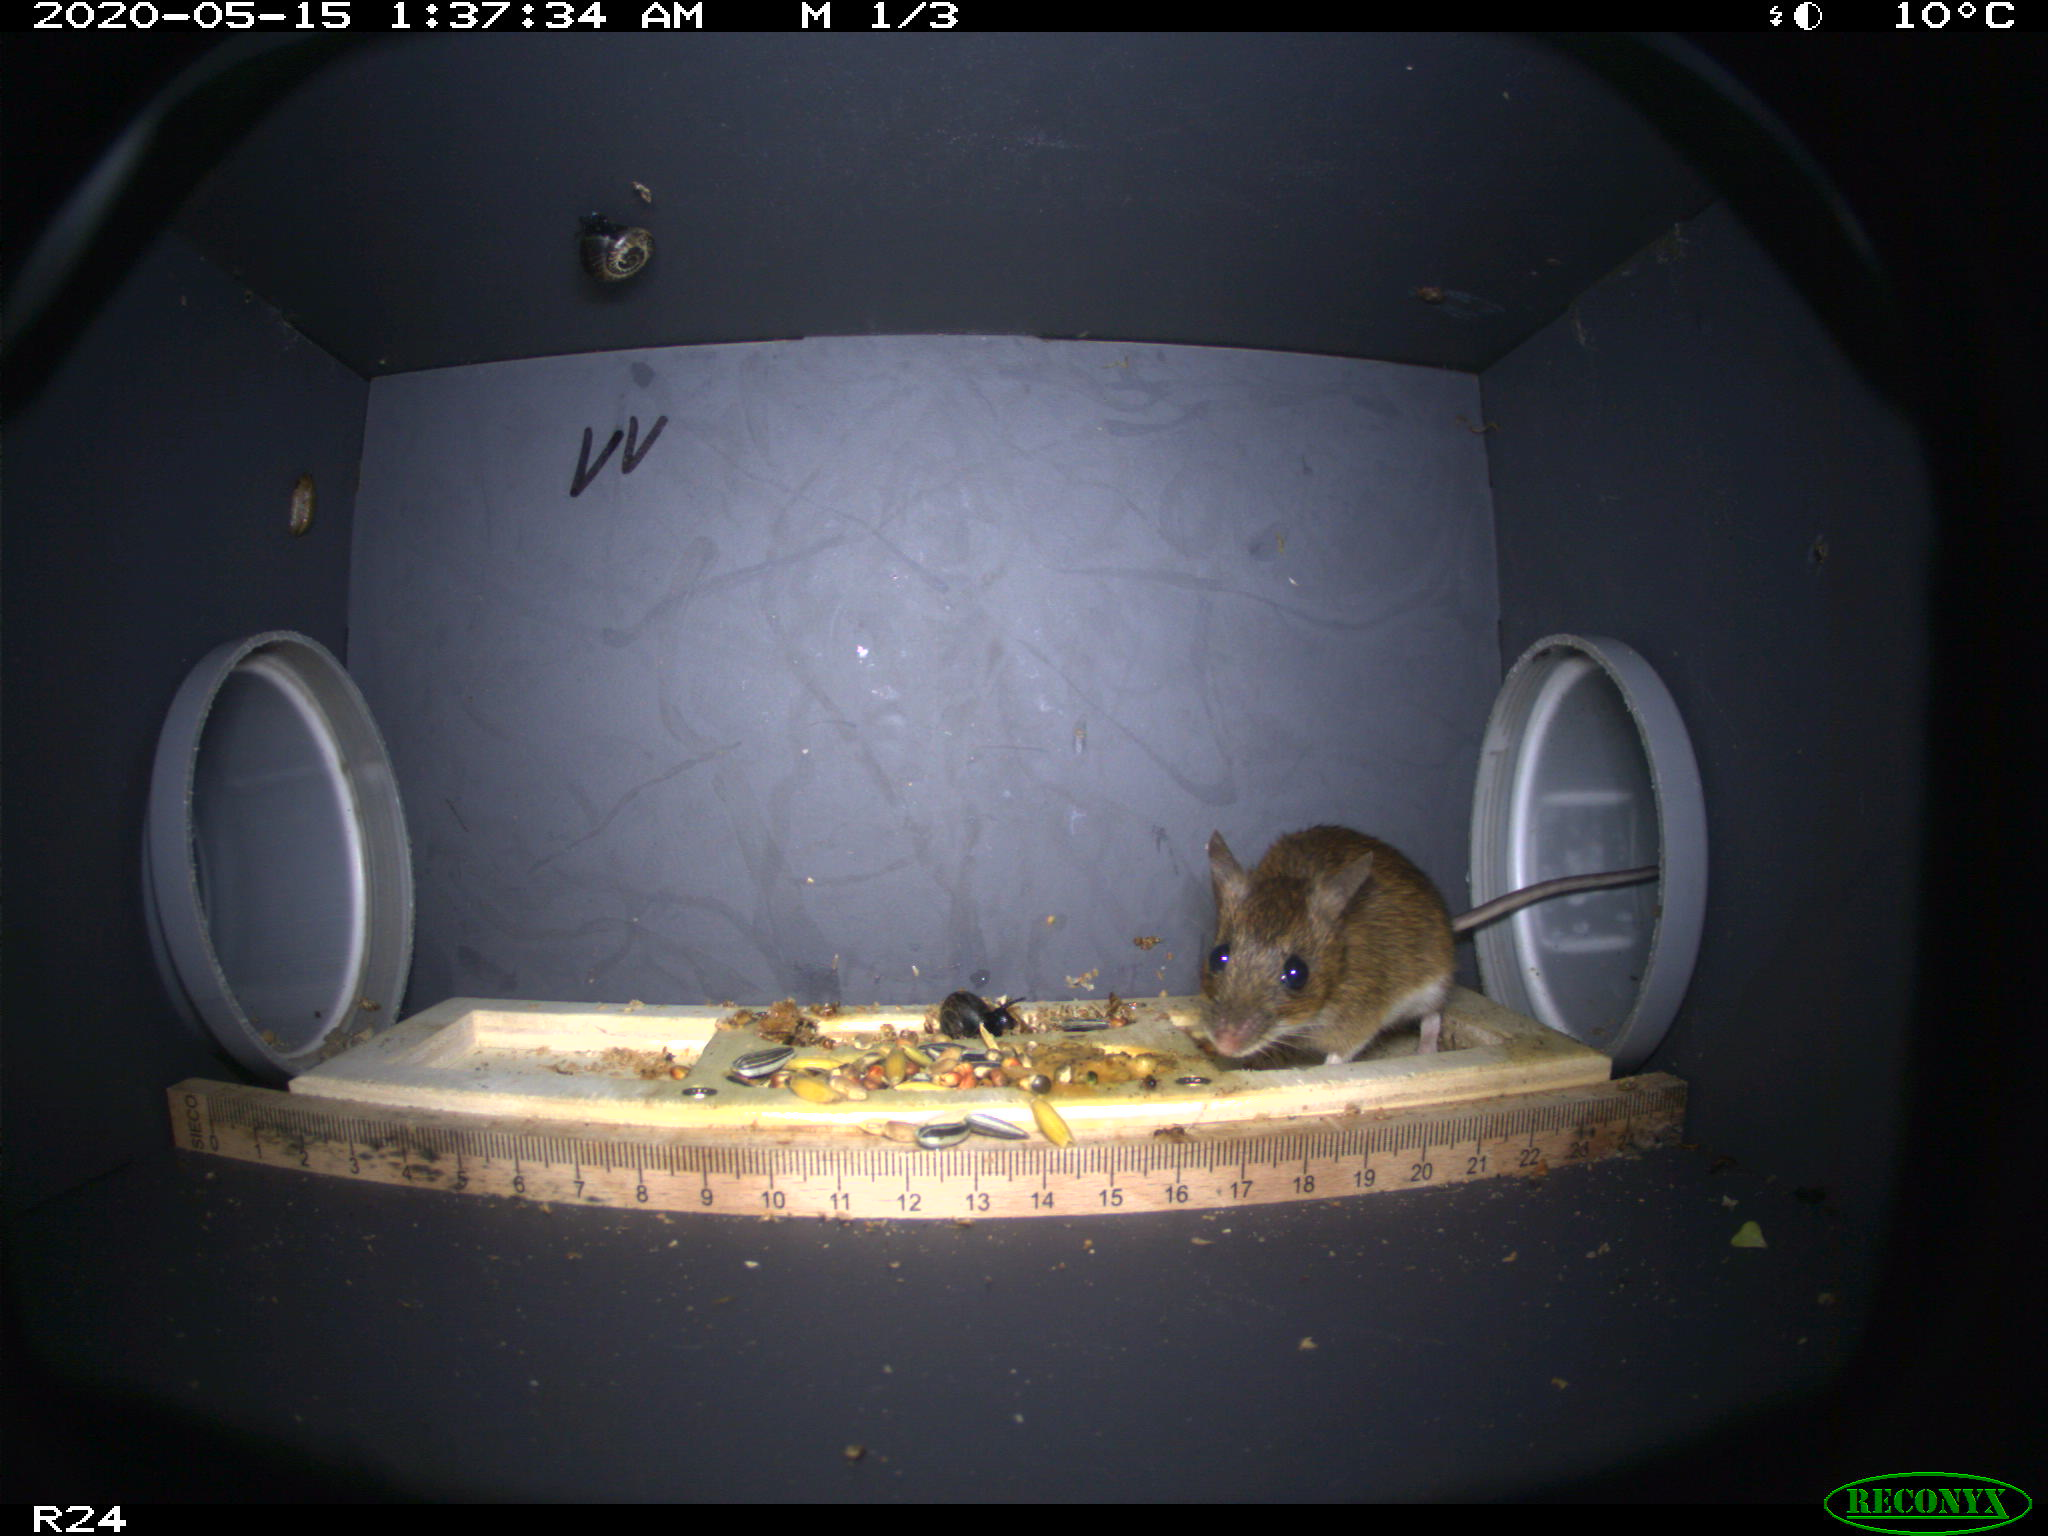

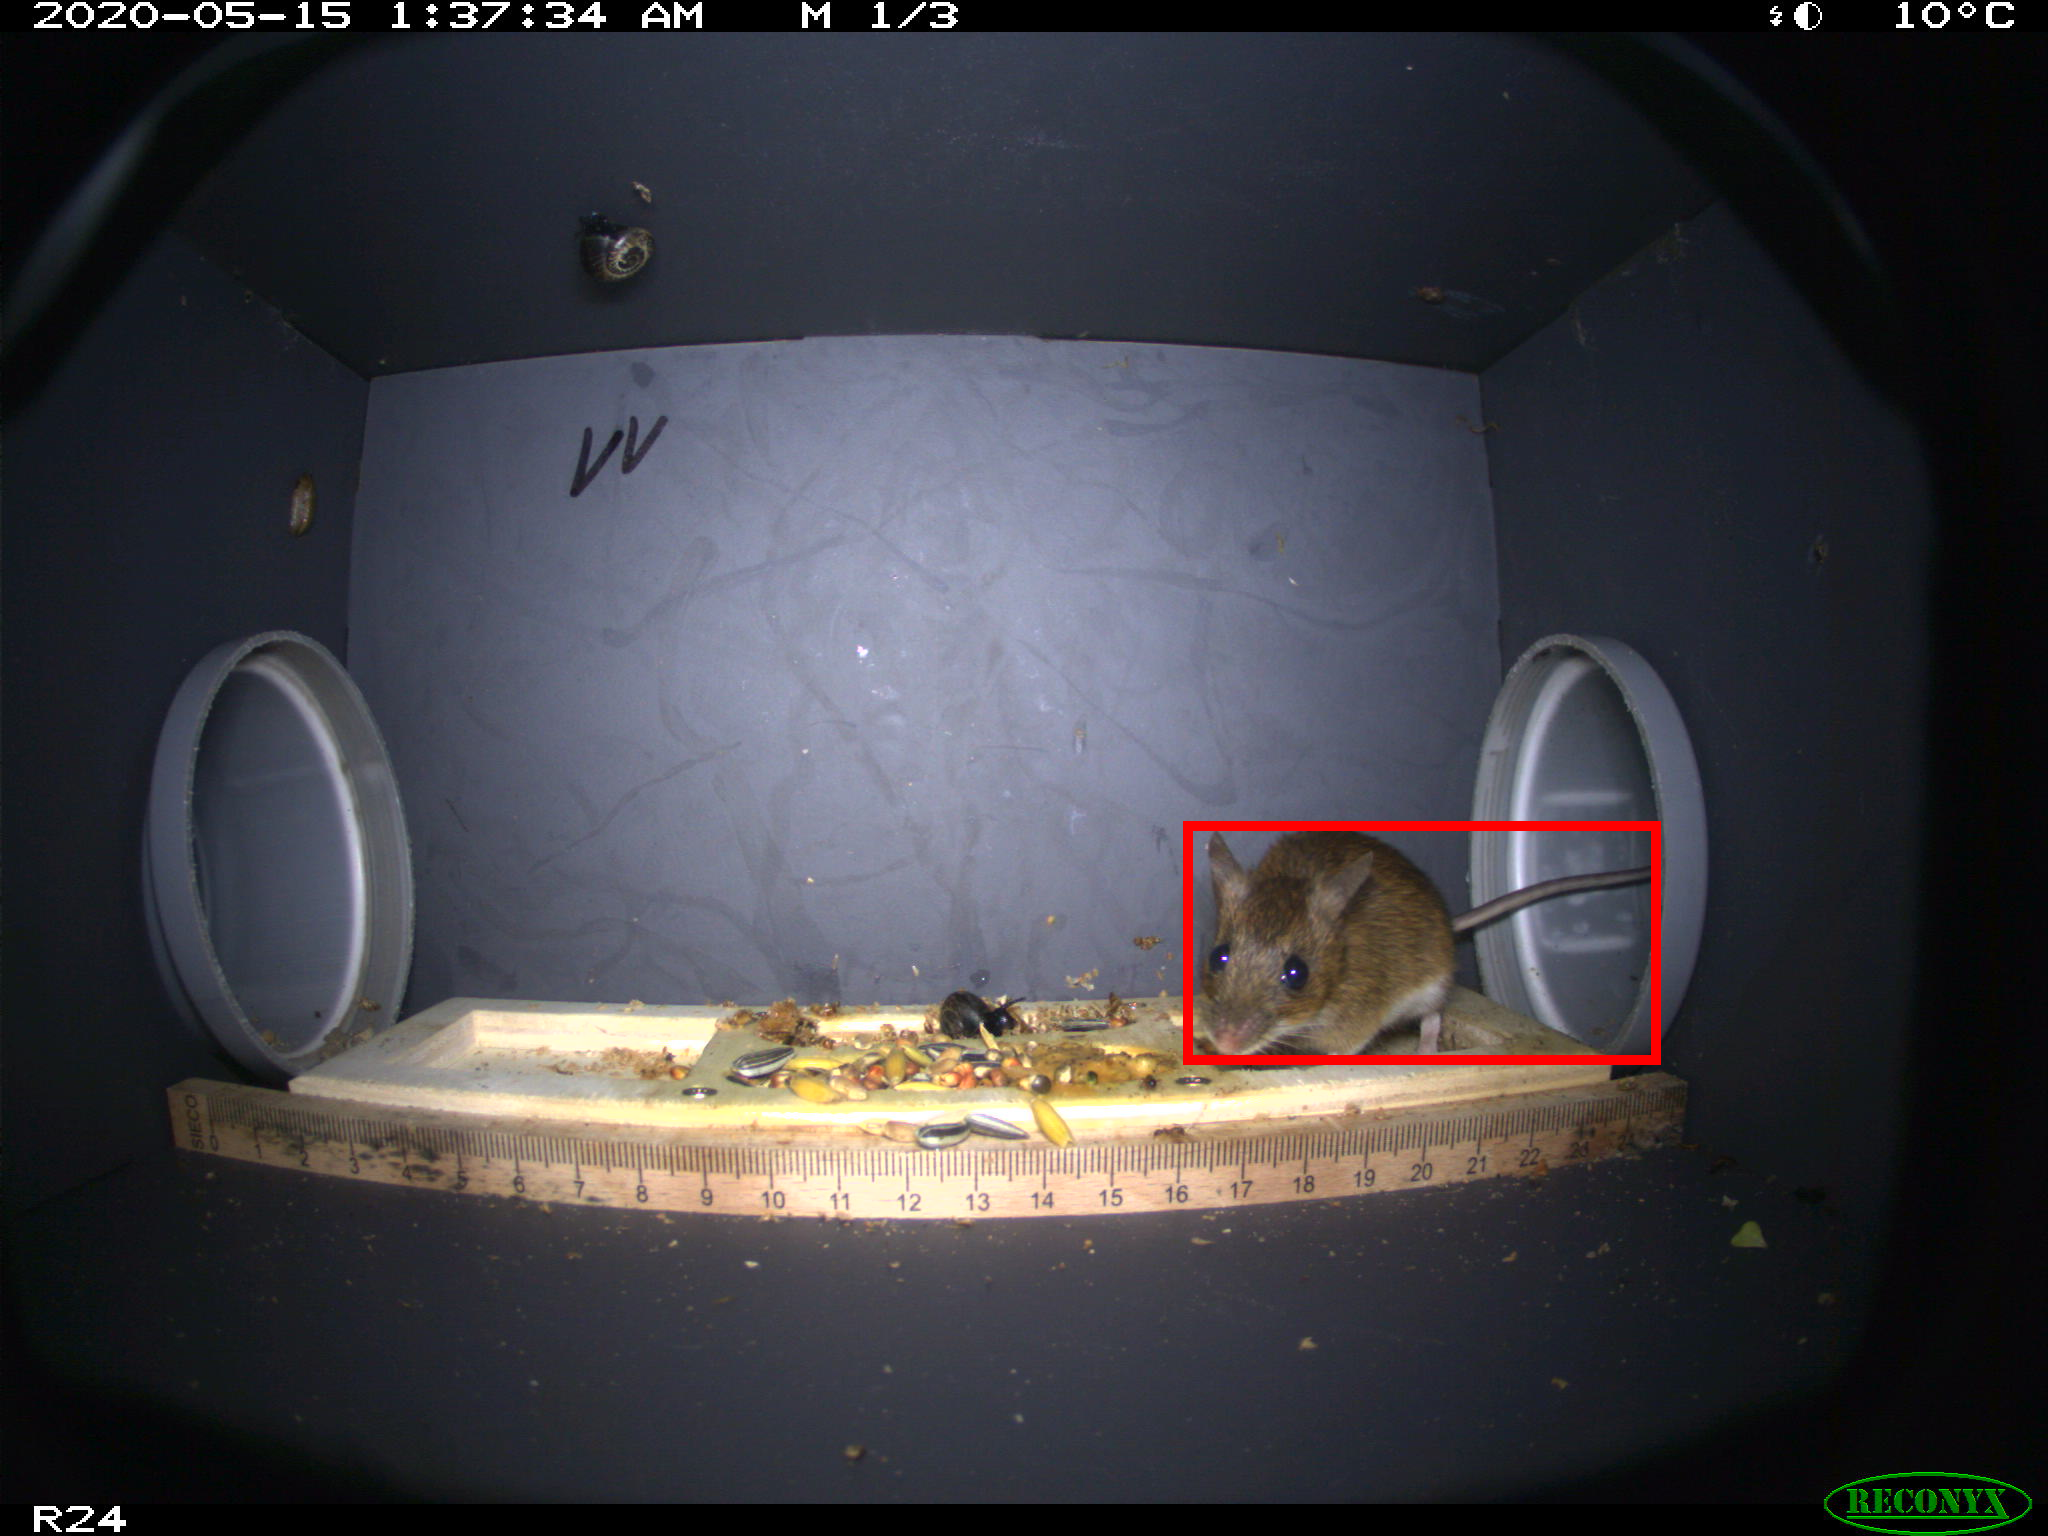

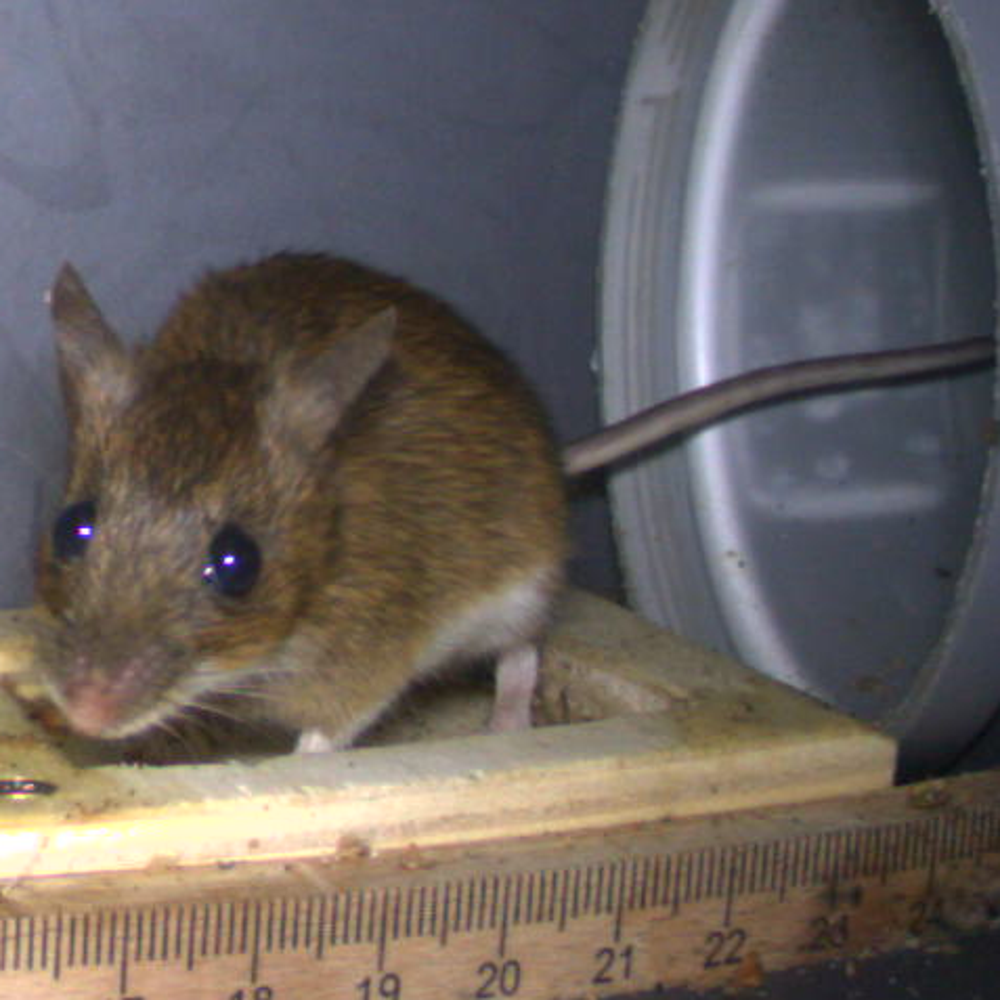

In [93]:
img_keys = ['img', 'img_bbox', 'img_cropped']

for key in img_keys:
    display(images[0][key])

In [88]:
df_joined.keys()

Index(['session', 'seq_id', 'n_files', 'file', 'class_label', 'conf', 'bbox',
       'file_path', 'idx', 'class_id', 'SerialNumber', 'fold', 'set',
       'pred_id', 'probs', 'correct', 'pred_label', 'probs_max'],
      dtype='object')

In [83]:
df_pred

idx   seq_id  class_id  class_label    SerialNumber  n_files  \
112848  112848  4002072         0  apodemus_sp  H550HF08161327        6   
112849  112849  4002072         0  apodemus_sp  H550HF08161327        6   
112850  112850  4002072         0  apodemus_sp  H550HF08161327        6   
112851  112851  4002072         0  apodemus_sp  H550HF08161327        6   

                                               file_path  \
112848  sessions/session_04/Testwoche2/WK06/IMG_0191.JPG   
112849  sessions/session_04/Testwoche2/WK06/IMG_0190.JPG   
112850  sessions/session_04/Testwoche2/WK06/IMG_0187.JPG   
112851  sessions/session_04/Testwoche2/WK06/IMG_0188.JPG   

                                    bbox   conf  fold   set  pred_id  \
112848  [0.6137, 0.5065, 0.1948, 0.1842]  0.974     0  test        0   
112849   [0.5195, 0.5136, 0.291, 0.1777]  0.971     0  test        0   
112850  [0.5781, 0.5351, 0.2329, 0.1582]  0.940     0  test        0   
112851   [0.5942, 0.5214, 0.1987, 0.164]  0.936     0  test        0   

                             probs  correct   pred_label  probs_max  
112848        [1.0, 0.0, 0.0, 0.0]     True  apodemus_sp     1.0000  
112849  [0.9999, 0.0, 0.0001, 0.0]     True  apodemus_sp     0.9999  
112850        [1.0, 0.0, 0.0, 0.0]     True  apodemus_sp     1.0000  
112851        [1.0, 0.0, 0.0, 0.0]     True  apodemus_sp     1.0000

## EXIF and OCR Tests

In [ ]:
from PIL.ExifTags import TAGS
import piexif
import pytesseract
pytesseract.pytesseract.tesseract_cmd = "/opt/homebrew/bin/tesseract"

image_path = '/Volumes/ExSSD/UserData/BA_Data/dataset/sessions/session_01/H550HF07158873_2/IMG_3961.JPG'

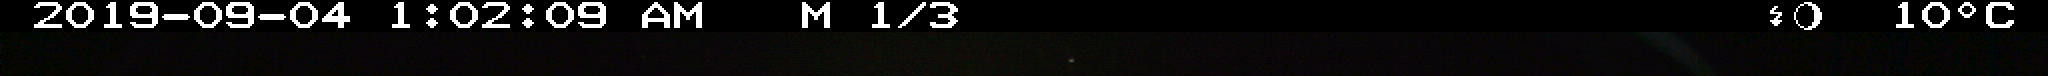

2019-09-04 1:02:09 AM M 1/3 #9 10°C



In [67]:
sample = Image.open(image_path)

width, height = sample.size
top_strip = sample.crop((0, 0, width, int(height * 0.05)))

display(top_strip)

text = pytesseract.image_to_string(top_strip)
print(text)

In [52]:
sample = Image.open(image_path)

exif_data = sample._getexif()

if exif_data:
    for tag_id, value in exif_data.items():
        tag = TAGS.get(tag_id, tag_id)
        print(f"{tag:25}: {value}")
else:
    print("No EXIF data found.")

ResolutionUnit           : 2
ExifOffset               : 174
Make                     : RECONYX
Model                    : HC550 HYPERFIRE    
DateTime                 : 2019:09:04 01:02:09
YCbCrPositioning         : 2
XResolution              : 72.0
YResolution              : 72.0
ExifVersion              : b'0220'
ComponentsConfiguration  : b'\x01\x02\x03\x00'
FlashPixVersion          : b'0100'
DateTimeOriginal         : 2019:09:04 01:02:09
DateTimeDigitized        : 2019:09:04 01:02:09
ColorSpace               : 1
ExifImageWidth           : 2048
ISOSpeedRatings          : 50
ExifImageHeight          : 1536
Flash                    : 25
ExposureMode             : 0
WhiteBalance             : 1
SceneCaptureType         : 3
ExposureTime             : 0.005439814814814815
MakerNote                : b'\x01\xf1\x04\x00\x02\x00\x00\x00\x16 )\x12M\x00\x01\x00\x03\x00\x00\x00)\x05\t\x00\x02\x00\x01\x00\t\x00\x04\x00\xe3\x07\x04\x00\x01\x002\x00\n\x00H\x005\x005\x000\x00H\x00F\x000\x007\x001\x

In [49]:
exif_dict = piexif.load(str(image_path))

for ifd_name in exif_dict:
    if ifd_name == "thumbnail":
        continue  # Skip non-dict entry

    for tag in exif_dict[ifd_name]:
        tag_name = piexif.TAGS[ifd_name][tag]["name"]
        value = exif_dict[ifd_name][tag]
        print(f"{tag_name:25}: {value}")

Make                     : b'RECONYX'
Model                    : b'HC550 HYPERFIRE\x00\x00\x00\x00'
XResolution              : (72, 1)
YResolution              : (72, 1)
ResolutionUnit           : 2
DateTime                 : b'2019:09:04 01:02:09'
YCbCrPositioning         : 2
ExifTag                  : 174
ExposureTime             : (47, 8640)
ISOSpeedRatings          : 50
ExifVersion              : b'0220'
DateTimeOriginal         : b'2019:09:04 01:02:09'
DateTimeDigitized        : b'2019:09:04 01:02:09'
ComponentsConfiguration  : b'\x01\x02\x03\x00'
Flash                    : 25
MakerNote                : b'\x01\xf1\x04\x00\x02\x00\x00\x00\x16 )\x12M\x00\x01\x00\x03\x00\x00\x00)\x05\t\x00\x02\x00\x01\x00\t\x00\x04\x00\xe3\x07\x04\x00\x01\x002\x00\n\x00H\x005\x005\x000\x00H\x00F\x000\x007\x001\x005\x008\x008\x007\x003\x00\x00\x00\xa0\x00\x00\x00 \x00\x9a\x00\x01\x00d\x00\xa6"R02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0